In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

class discriminator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super(discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.conv5 = nn.Conv2d(d*8, 1, 4, 1, 0)
        #self.dense = nn.Linear(9, 1)
        self.leaky_relu = nn.LeakyReLU()

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        x = self.conv1(input)
        x = self.leaky_relu(self.conv2_bn(self.conv2(x)))
        x = self.leaky_relu(self.conv3_bn(self.conv3(x)))
        x = self.leaky_relu(self.conv4_bn(self.conv4(x)))
        x = self.conv5(x).sigmoid()

        return x

class discriminator2(nn.Module):
    # initializers
    def __init__(self, d=128):
        super(discriminator2, self).__init__()
        self.conv_bn1 = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )

        self.dp = nn.Dropout(0.4)

        self.conv_bn2 = nn.Sequential(
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )

        self.conv_bn3 = nn.Sequential(
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2)
        )

        self.conv_bn4 = nn.Sequential(
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2)
        )

        self.convs = nn.ModuleList([
            self.conv_bn1,
            self.conv_bn2,
            self.conv_bn3, 
            self.conv_bn4
        ])

        self.dense = nn.Linear(512*6*6, 2)

    # forward method
    def forward(self, x):
        for layer in self.convs:
            x = layer(x)
            x = self.dp(x)
        x = self.dense(x.reshape(-1, 512*6*6)).log_softmax(1)
        return x   

x = torch.rand((1, 3, 96, 96))
d = discriminator2()
d(x).shape

torch.Size([1, 2])

In [2]:
# G(z)
class generator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super(generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(100, d*8, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*8)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 3, 4, 2, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        # x = F.relu(self.deconv1(input))
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = F.tanh(self.deconv5(x))

        return x

class ShortCut(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers

    def forward(self, x):
        return x + self.layers(x)

class BasicBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_bn1 = nn.Sequential(
            nn.Conv2d(2, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.conv_bn2 = nn.Sequential(
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256)
        )

        self.shortcut = ShortCut(
            nn.Sequential(
            nn.Conv2d(256, 256, 1, 1, 0),
            nn.BatchNorm2d(256),
            nn.ReLU()
            )
        )

    def forward(self, x):
        x = self.conv_bn1(x)
        x = self.conv_bn2(x)
        return self.shortcut(x) + x

class generator2(nn.Module):
    def __init__(self, d=128):
        super().__init__()
        self.residual_block = BasicBlock()  

        self.deconv_bn1 = nn.Sequential(
            nn.ConvTranspose2d(256, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.deconv_bn2 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.deconv_bn3 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        ) 

        self.deconvs = nn.ModuleList([
            self.deconv_bn1,
            self.deconv_bn2,
            self.deconv_bn3,
        ])

        self.deconv_last = nn.Sequential(
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.ReLU()
        )
        self.apply(self.weight_init)

    def weight_init(self, layer):
        if isinstance(layer, nn.ConvTranspose2d):
            nn.init.kaiming_normal_(layer.weight, a=.02)
            nn.init.uniform_(layer.bias, 0.3)
    
    def forward(self, x):
        x = self.residual_block(x)
        for layer in self.deconvs:
            x = layer(x)

        return self.deconv_last(x)

        

In [3]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

g_lr=1e-4
d_lr=1e-4
# network
G = generator2()
D = discriminator2()
# G.weight_init(mean=0.0, std=0.02)
# D.weight_init(mean=0.0, std=0.02)
G = G.cuda()
D = D.cuda()

# Binary Cross Entropy loss
BCE_loss = nn.NLLLoss()

# Adam optimizer
G_optimizer = optim.AdamW(G.parameters(), lr=g_lr)#, betas=(0.5, 0.999))
D_optimizer = optim.AdamW(D.parameters(), lr=d_lr)#, betas=(0.5, 0.999))

# G_schedule = CosineAnnealingLR(G_optimizer, 50)
# D_schedule = CosineAnnealingLR(D_optimizer, 20)


In [4]:
d = torch.load('D:/desktop/model_dcgan.pth')
G.load_state_dict(d['G'])
D.load_state_dict(d['D'])

# G_optimizer.load_state_dict(d['G_optim'])
# D_optimizer.load_state_dict(d['D_optim'])

epochs = 458#d['ep'] 

In [2]:
from torch.utils.data import Dataset, DataLoader, IterableDataset
import glob
from torchvision.io import read_image
from torchvision.transforms import Normalize, Compose, Resize, ColorJitter, CenterCrop, RandomVerticalFlip, Lambda

class FacesDataSet(Dataset):
    def __init__(self, path):
        self.paths = glob.glob(path+r'*.jpg')[:300]
        self.transform = Compose([
            # ColorJitter(0.1),
            # RandomVerticalFlip(p=.2),
            #Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            Lambda(lambda img: img / 127.5 - 1)
            # Resize(64)   
        ])
        
    def __getitem__(self, index):     
        p = self.paths[index]
        img = read_image(p).float() # [3, h, w], e.g. h=w=96
        img = self.transform(img)
        return img

    def __len__(self):
        return len(self.paths)

    
dataset = FacesDataSet('D:/desktop/faces/')
dl = DataLoader(dataset, batch_size=32, drop_last=True)

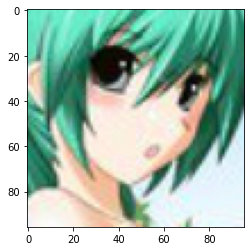

In [20]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
for i in dl:
    # i = ((i[0]+1).permute(1, 2, 0) / 2 *255).int()
    # print(i.max(), i.min())
    grid = make_grid(i[0], 1, normalize=True)
    plt.imshow(grid.permute(1, 2, 0))
    break

In [7]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('./logs/exp6')

In [8]:
import time
import matplotlib.pyplot as plt
from torchvision.utils import make_grid, save_image
import os
from tqdm import tqdm

bar = tqdm()
bar.set_description()

train_epoch = 900
#fixed_z_ = torch.randn((5 * 5, 100)).view(-1, 100, 1, 1).cuda()    # fixed noise

print('training start!')
start_time = time.time()
for epoch in range(700, train_epoch):
    D_losses = []
    G_losses = []
    epoch_start_time = time.time()
    for x_ in dl:
        # train discriminator D
        D.zero_grad()

        mini_batch = x_.size()[0]

        y_real_ = torch.ones(mini_batch).long()
        y_fake_ = torch.zeros(mini_batch).long()

        x_, y_real_, y_fake_ = x_.cuda(), y_real_.cuda(), y_fake_.cuda()
        D_result = D(x_).squeeze()
        D_real_loss = BCE_loss(D_result, y_real_)

        z_ = torch.randn((mini_batch, 72)).view(-1, 2, 6, 6)
        z_ = z_.cuda()
        G_result = G(z_)

        D_result = D(G_result).squeeze()
        D_fake_loss = BCE_loss(D_result, y_fake_)
        D_fake_score = D_result.data.mean()

        D_train_loss = D_real_loss + D_fake_loss

        # if epoch%3==0:
        D_train_loss.backward()
        D_optimizer.step()
        # D_schedule.step()

        D_losses.append(D_train_loss.item())

        # train generator G
        G.zero_grad()

        z_ = torch.randn((mini_batch, 72)).view(-1, 2, 6, 6)
        z_ = z_.cuda()

        G_result = G(z_)
        D_result = D(G_result).squeeze()
        G_train_loss = BCE_loss(D_result, y_real_)
        G_train_loss.backward()
        G_optimizer.step()
        # G_schedule.step()

        G_losses.append(G_train_loss.item())

    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time

    d_loss = torch.mean(torch.FloatTensor(D_losses))
    g_loss = torch.mean(torch.FloatTensor(G_losses))
    print('[%d/%d] - ptime: %.2f, loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), train_epoch, per_epoch_ptime, torch.mean(torch.FloatTensor(D_losses)),
                                                              torch.mean(torch.FloatTensor(G_losses))))

    writer.add_scalars('loss', {'d_loss':d_loss.item(), 'g_loss': g_loss.item()}, global_step=epoch)

    if epoch%20==0:
        grid = make_grid(G_result, 8, normalize=True)
        writer.add_image('generate_img', grid, epoch)
        save_image(grid, f'D:\desktop\generation\{epoch}.jpg')

model_dict = {
    'G': G.state_dict(),
    'D': D.state_dict(),
    'G_optim': G_optimizer.state_dict(),
    'D_optim': D_optimizer.state_dict(),
    'ep': train_epoch,
    # 'D_schedule': D_schedule.state_dict(),
    # 'G_schedule': G_schedule.state_dict()
}
torch.save(model_dict, 'D:/desktop/model_dcgan.pth')





training start!
[701/900] - ptime: 1.28, loss_d: 0.090, loss_g: 12.461
[702/900] - ptime: 1.22, loss_d: 0.116, loss_g: 10.390
[703/900] - ptime: 1.21, loss_d: 0.065, loss_g: 12.295
[704/900] - ptime: 1.22, loss_d: 0.073, loss_g: 11.141
[705/900] - ptime: 1.25, loss_d: 0.081, loss_g: 11.620
[706/900] - ptime: 1.17, loss_d: 0.077, loss_g: 11.698
[707/900] - ptime: 1.19, loss_d: 0.079, loss_g: 11.344
[708/900] - ptime: 1.25, loss_d: 0.102, loss_g: 10.728
[709/900] - ptime: 1.17, loss_d: 0.108, loss_g: 11.501
[710/900] - ptime: 1.16, loss_d: 0.146, loss_g: 11.081
[711/900] - ptime: 1.16, loss_d: 0.036, loss_g: 12.880
[712/900] - ptime: 1.18, loss_d: 0.080, loss_g: 9.589
[713/900] - ptime: 1.22, loss_d: 0.072, loss_g: 11.156
[714/900] - ptime: 1.14, loss_d: 0.086, loss_g: 11.840
[715/900] - ptime: 1.14, loss_d: 0.076, loss_g: 11.955
[716/900] - ptime: 1.15, loss_d: 0.071, loss_g: 11.536
[717/900] - ptime: 1.13, loss_d: 0.071, loss_g: 11.154
[718/900] - ptime: 1.17, loss_d: 0.064, loss_g: 11

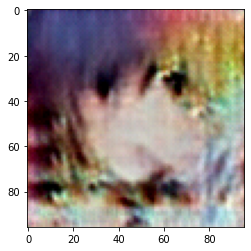

In [70]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

z_ = torch.randn((1, 72), ).view(-1, 2, 6, 6)
z_ = z_.cuda()
G_result = G(z_)
grid = make_grid(G_result, 1, normalize=True)
plt.imshow(grid.detach().cpu().permute(1, 2, 0))